<a href="https://colab.research.google.com/github/202124660/ST456/blob/main/ST456_Assessment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P1.1

First we must import the necessary libraries and load & pre-process the data (splitting it into predictors & responses):

In [19]:
# import necessary libraries
from pandas import read_csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
import h5py
import matplotlib.pyplot as plt

In [20]:
# load the datasets
trainDF = read_csv('/content/train-1.csv', header=None)
testDF = read_csv('/content/test-1.csv', header=None)
trainDF.head

# splitting the datasets into features (X) and target (Y)
X_train = trainDF.iloc[:,:-1].to_numpy()
Y_train = trainDF.iloc[:,-1].to_numpy()
X_test = testDF.iloc[:,:-1].to_numpy()
Y_test = testDF.iloc[:,-1].to_numpy()

# determine the number of input features
n_features = X_train.shape[1]

# set lat_dim and seed
lat_dim = 5
seed_num = 1

We now implement the neural network. Here we are using the Functional API from `tf.keras`, because it is more flexible than the Sequential API.

We are implementing a $(\phi,\rho)$-sum-decomposition architecture, so for the $\phi$ section, we add a dense hidden layer after the input (of width 100), followed by an output layer (with hyperparameter width `lat_dim`) which we then sum over using `tf.reduce_sum()`, reducing the dimensionality to 1, before feeding this result into the $\rho$ section.

For the $\rho$ section, we have another hidden layer (of width 100) followed by an output layer with output dimension of 1.

All of the layers have a ReLu activation function applied to the layer, apart from the final output layer. The reason for not applying an activation function to the output layer is because this is a regression problem, not a classification problem (since the output is continuous).

Finally, `final_model.summary()` shows the network architecture, giving the output shapes of each layer, as well as the number of parameters used by the model (1,906 in total).

In [21]:
# create model
inputs = keras.Input(shape=(n_features,), name="inputs")
# phi section
x = keras.layers.Dense(100, activation='relu', input_shape=(n_features,), name="phi_hidden_layer")(inputs)
x = keras.layers.Dense(lat_dim, activation='relu', name="phi_output_layer")(x)
# take the sum
x = tf.reduce_sum(x, axis=1, keepdims=True, name="sum_phi_outputs")
# rho section
x = keras.layers.Dense(100, activation='relu', input_shape=(1,), name="rho_hidden_layer")(x)
outputs = keras.layers.Dense(1, name="rho_output_layer")(x)

final_model = keras.Model(inputs=inputs, outputs=outputs, name="final_model")
final_model.summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 phi_hidden_layer (Dense)    (None, 100)               1100      
                                                                 
 phi_output_layer (Dense)    (None, 5)                 505       
                                                                 
 tf.math.reduce_sum (TFOpLam  (None, 1)                0         
 bda)                                                            
                                                                 
 rho_hidden_layer (Dense)    (None, 100)               200       
                                                                 
 rho_output_layer (Dense)    (None, 1)                 101       
                                                       

We can also represent the neural network as an graph, which shows the layers and their sizes along with the direction of the network:

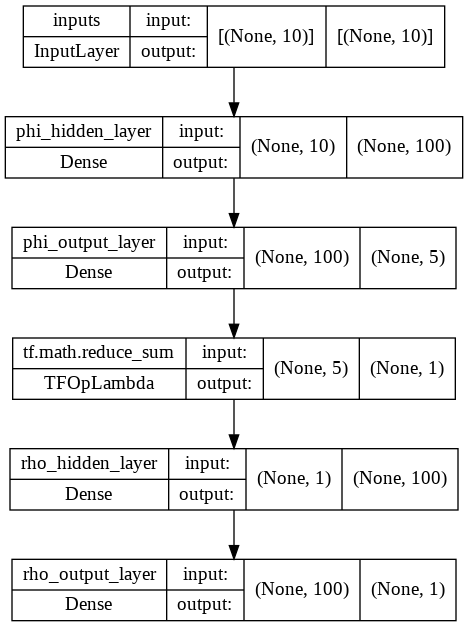

In [22]:
# plot model
keras.utils.plot_model(final_model, "rho_model_with_shape_info.png", show_shapes=True)

We now compile the model, setting the learning rate to 1e-4 as given, and the loss function as the MSE. We are using stochastic gradient descent for our optimiser.

We also train the model on the training dataset for 10 epochs, with a batch size of 128 and setting the validation dataset to be 10% of the training dataset.

In [23]:
# compile the model
final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4), loss='mean_squared_error')
# train the model
final_model.fit(X_train, Y_train, epochs=10, batch_size=128, verbose=2, validation_split=0.1)

Epoch 1/10
704/704 - 2s - loss: 0.2361 - val_loss: 0.1835 - 2s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.1508 - val_loss: 0.1212 - 1s/epoch - 1ms/step
Epoch 3/10
704/704 - 1s - loss: 0.1017 - val_loss: 0.0831 - 1s/epoch - 1ms/step
Epoch 4/10
704/704 - 1s - loss: 0.0709 - val_loss: 0.0589 - 1s/epoch - 1ms/step
Epoch 5/10
704/704 - 1s - loss: 0.0513 - val_loss: 0.0435 - 1s/epoch - 1ms/step
Epoch 6/10
704/704 - 1s - loss: 0.0388 - val_loss: 0.0338 - 987ms/epoch - 1ms/step
Epoch 7/10
704/704 - 1s - loss: 0.0310 - val_loss: 0.0278 - 971ms/epoch - 1ms/step
Epoch 8/10
704/704 - 1s - loss: 0.0261 - val_loss: 0.0241 - 960ms/epoch - 1ms/step
Epoch 9/10
704/704 - 1s - loss: 0.0231 - val_loss: 0.0218 - 963ms/epoch - 1ms/step
Epoch 10/10
704/704 - 1s - loss: 0.0214 - val_loss: 0.0205 - 992ms/epoch - 1ms/step


# P1.2

We now re-write the model within some functions, as this allows us to re-use the model without having to write it all out again each time.

In [33]:
# this clears the session to prevent slowdown after running lots of models successively, as we will be doing
def reset_backend():
    tf.keras.backend.clear_session()

# this function is useful for reproducability when testing and debugging, but not currently used
def reset_seeds():
    import os
    os.environ['PYTHONHASHSEED']=str(seed_num)
    import random
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed

# create the model architecture
def create_model(lat_dim=5, a_fn="relu"):
    reset_backend()
    inputs = keras.Input(shape=(n_features,), name="inputs")
    # phi part of model
    x = keras.layers.Dense(100, activation=a_fn, input_shape=(n_features,), name="phi_hidden_layer")(inputs)
    x = keras.layers.Dense(lat_dim, activation=a_fn, name="phi_output_layer")(x)
    # take the sum
    x = tf.reduce_sum(x, axis=1, keepdims=True, name="sum_phi_outputs")
    # rho part of model
    x = keras.layers.Dense(100, activation=a_fn, input_shape=(1,), name="rho_hidden_layer")(x)
    outputs = keras.layers.Dense(1, name="rho_output_layer")(x)
    return keras.Model(inputs=inputs, outputs=outputs, name="final_model")

# compile and train the model, then print the test MSE
def run_model(model, n_epochs=10, lr=1e-4):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='mean_squared_error')
    history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=128, verbose=2, validation_split=0.1)
    print('Test MSE: {:.4f}'.format(model.evaluate(X_test, Y_test, verbose=0)))
    return history

We now train the model for 10 epochs at two different values of `lat_dim`.


Training model with latent dimension (lat_dim) of 5:
Epoch 1/10
704/704 - 2s - loss: 0.2555 - val_loss: 0.1935 - 2s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.1611 - val_loss: 0.1328 - 1s/epoch - 2ms/step
Epoch 3/10
704/704 - 1s - loss: 0.1136 - val_loss: 0.0954 - 995ms/epoch - 1ms/step
Epoch 4/10
704/704 - 1s - loss: 0.0828 - val_loss: 0.0705 - 1s/epoch - 1ms/step
Epoch 5/10
704/704 - 1s - loss: 0.0621 - val_loss: 0.0537 - 1s/epoch - 2ms/step
Epoch 6/10
704/704 - 1s - loss: 0.0480 - val_loss: 0.0422 - 996ms/epoch - 1ms/step
Epoch 7/10
704/704 - 1s - loss: 0.0385 - val_loss: 0.0345 - 1s/epoch - 1ms/step
Epoch 8/10
704/704 - 1s - loss: 0.0320 - val_loss: 0.0293 - 983ms/epoch - 1ms/step
Epoch 9/10
704/704 - 1s - loss: 0.0277 - val_loss: 0.0258 - 1s/epoch - 1ms/step
Epoch 10/10
704/704 - 1s - loss: 0.0248 - val_loss: 0.0234 - 1s/epoch - 2ms/step
Test MSE: 0.0239


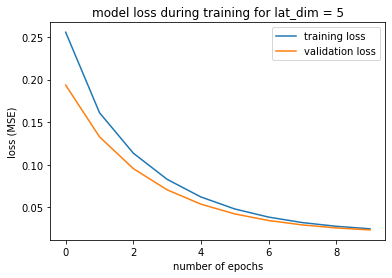


Training model with latent dimension (lat_dim) of 100:
Epoch 1/10
704/704 - 2s - loss: 0.0237 - val_loss: 0.0096 - 2s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.0097 - val_loss: 0.0096 - 1s/epoch - 2ms/step
Epoch 3/10
704/704 - 1s - loss: 0.0097 - val_loss: 0.0095 - 1s/epoch - 2ms/step
Epoch 4/10
704/704 - 1s - loss: 0.0096 - val_loss: 0.0095 - 1s/epoch - 2ms/step
Epoch 5/10
704/704 - 1s - loss: 0.0096 - val_loss: 0.0095 - 1s/epoch - 2ms/step
Epoch 6/10
704/704 - 1s - loss: 0.0095 - val_loss: 0.0094 - 1s/epoch - 2ms/step
Epoch 7/10
704/704 - 1s - loss: 0.0095 - val_loss: 0.0094 - 1s/epoch - 2ms/step
Epoch 8/10
704/704 - 1s - loss: 0.0094 - val_loss: 0.0093 - 1s/epoch - 2ms/step
Epoch 9/10
704/704 - 1s - loss: 0.0094 - val_loss: 0.0093 - 1s/epoch - 2ms/step
Epoch 10/10
704/704 - 1s - loss: 0.0093 - val_loss: 0.0092 - 1s/epoch - 2ms/step
Test MSE: 0.0095


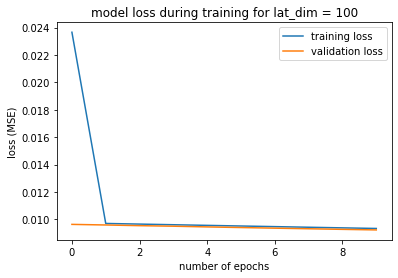

In [32]:
for lat_dim in [5, 100]:
    print("\nTraining model with latent dimension (lat_dim) of {:d}:".format(lat_dim))
    model = create_model(lat_dim=lat_dim)
    history = run_model(model)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss during training for lat_dim = {:d}'.format(lat_dim))
    plt.ylabel('loss (MSE)')
    plt.xlabel('number of epochs')
    plt.legend(['training loss', 'validation loss'], loc='upper right')
    plt.show()

From these results, we have the test MSE for `lat_dim = 5` is 0.0239, whilst the test MSE for `lat_dim = 100` is 0.0095 (about 60% smaller). At first this seemed to indicate that `5` is perhaps too few dimensions for the output layer of the $\phi$ section, resulting in insufficient flexibility. However, based on the results of P1.5 below, it is actually the learning rate (1e-4) that is too small to optimise sufficiently with `lat_dim = 5`.

The test MSEs for both models are similar to the training MSEs, so we do not need to worry about overfitting.

An interesting observation is that validation loss is smaller than training loss in both graphs, for every epoch. This is likely because validation loss is computed *after* the epoch, whilst training loss is the average training loss over the current epoch, and due the the relatively quick fall in loss (especially at the start), this has a relatively big impact.

Another observation is that for the `lat_dim = 100` model, the training loss falls very steeply after the first epoch, then quickly flattens out. This is due to the nature of training the model: at the start of the first epoch, the network is essentially guessing completely at random, and not much training is needed to significantly improve from random guesses. Once the model has been trained, even just by one epoch, reducing the loss becomes significantly more difficult. This effect is seen for the `lat_dim = 100` model rather than the `lat_dim = 5` model, because the number of parameters is 11,501 for `lat_dim = 100`, compared to just 1,906 for `lat_dim = 5`. With over 6 times as many parameters, the model is able to fit the first epoch data much more precisely when `lat_dim = 100`.

# P1.3

We now train with three different learning rates:


Training model with learning rate of 0.01:
Epoch 1/10
704/704 - 2s - loss: 0.0188 - val_loss: 0.0066 - 2s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.0055 - val_loss: 0.0053 - 1s/epoch - 2ms/step
Epoch 3/10
704/704 - 1s - loss: 0.0045 - val_loss: 0.0044 - 1s/epoch - 2ms/step
Epoch 4/10
704/704 - 1s - loss: 0.0042 - val_loss: 0.0043 - 1s/epoch - 2ms/step
Epoch 5/10
704/704 - 1s - loss: 0.0041 - val_loss: 0.0050 - 1s/epoch - 2ms/step
Epoch 6/10
704/704 - 1s - loss: 0.0040 - val_loss: 0.0039 - 1s/epoch - 2ms/step
Epoch 7/10
704/704 - 1s - loss: 0.0040 - val_loss: 0.0049 - 1s/epoch - 2ms/step
Epoch 8/10
704/704 - 1s - loss: 0.0040 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 9/10
704/704 - 1s - loss: 0.0039 - val_loss: 0.0053 - 1s/epoch - 2ms/step
Epoch 10/10
704/704 - 1s - loss: 0.0040 - val_loss: 0.0047 - 1s/epoch - 2ms/step
Test MSE: 0.0048


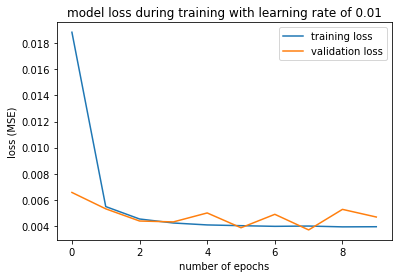


Training model with learning rate of 0.1:
Epoch 1/10
704/704 - 2s - loss: 0.3665 - val_loss: 0.0190 - 2s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0189 - 1s/epoch - 2ms/step
Epoch 3/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0189 - 1s/epoch - 2ms/step
Epoch 4/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0190 - 1s/epoch - 2ms/step
Epoch 5/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0193 - 1s/epoch - 2ms/step
Epoch 6/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0190 - 1s/epoch - 2ms/step
Epoch 7/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0189 - 1s/epoch - 2ms/step
Epoch 8/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0189 - 1s/epoch - 2ms/step
Epoch 9/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0190 - 1s/epoch - 2ms/step
Epoch 10/10
704/704 - 1s - loss: 0.0190 - val_loss: 0.0190 - 1s/epoch - 2ms/step
Test MSE: 0.0192


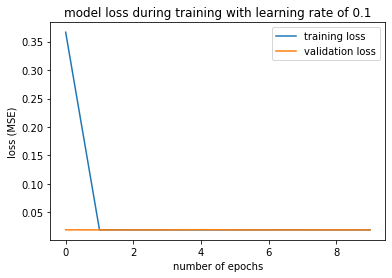


Training model with learning rate of 0.5:
Epoch 1/10
704/704 - 2s - loss: 0.5235 - val_loss: 0.0189 - 2s/epoch - 2ms/step
Epoch 2/10
704/704 - 1s - loss: 0.0192 - val_loss: 0.0191 - 1s/epoch - 2ms/step
Epoch 3/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0193 - 1s/epoch - 2ms/step
Epoch 4/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0191 - 1s/epoch - 2ms/step
Epoch 5/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0205 - 1s/epoch - 2ms/step
Epoch 6/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0202 - 1s/epoch - 2ms/step
Epoch 7/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0219 - 1s/epoch - 2ms/step
Epoch 8/10
704/704 - 1s - loss: 0.0192 - val_loss: 0.0195 - 1s/epoch - 2ms/step
Epoch 9/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0194 - 1s/epoch - 2ms/step
Epoch 10/10
704/704 - 1s - loss: 0.0191 - val_loss: 0.0190 - 1s/epoch - 2ms/step
Test MSE: 0.0193


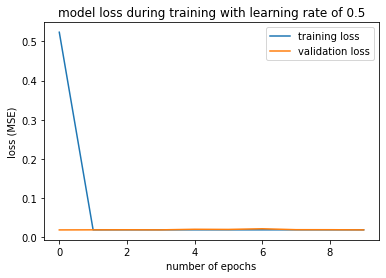

In [38]:
for lr in [0.01, 0.1, 0.5]:
    print("\nTraining model with learning rate of {:g}:".format(lr))
    model = create_model(lat_dim=100)
    history = run_model(model, n_epochs=10, lr=lr)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss during training with learning rate of {:g}'.format(lr))
    plt.ylabel('loss (MSE)')
    plt.xlabel('number of epochs')
    plt.legend(['training loss', 'validation loss'], loc='upper right')
    plt.show()

The test MSEs for each learning rate are 0.0048 for `lr=0.01`, 0.0192 for `lr=0.1` and 0.0193 for `lr=0.5`. This shows that `0.01` is clearly the best choice out of the three, with a test MSE 75% smaller than the other choices.

Additionally, for learning rates of `0.1` and `0.5`, after the first epoch, the validation (and training) loss stays almost constant throughout the training, which indicates that the learning rate was too high, since the model settled on a local minimum.

For the `0.01` learning rate, however, there does appear to be some overfitting, since the validation MSE starts to fluctuate whilst the training MSE decreases slightly. However, this fluctuation is not too extreme, and the test MSE is not too much higher than the training MSE, so any overfitting is likely to be mild.

# P1.4

Next we compare the performance of the ReLu activation function compared to the sigmoid activation function:


Training model with relu activation function:
Epoch 1/50
704/704 - 2s - loss: 0.0166 - val_loss: 0.0058 - 2s/epoch - 3ms/step
Epoch 2/50
704/704 - 1s - loss: 0.0050 - val_loss: 0.0048 - 1s/epoch - 2ms/step
Epoch 3/50
704/704 - 1s - loss: 0.0043 - val_loss: 0.0041 - 1s/epoch - 2ms/step
Epoch 4/50
704/704 - 1s - loss: 0.0041 - val_loss: 0.0039 - 1s/epoch - 2ms/step
Epoch 5/50
704/704 - 1s - loss: 0.0040 - val_loss: 0.0038 - 1s/epoch - 2ms/step
Epoch 6/50
704/704 - 1s - loss: 0.0039 - val_loss: 0.0038 - 1s/epoch - 2ms/step
Epoch 7/50
704/704 - 1s - loss: 0.0039 - val_loss: 0.0043 - 1s/epoch - 2ms/step
Epoch 8/50
704/704 - 1s - loss: 0.0039 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 9/50
704/704 - 1s - loss: 0.0038 - val_loss: 0.0040 - 1s/epoch - 2ms/step
Epoch 10/50
704/704 - 1s - loss: 0.0038 - val_loss: 0.0040 - 1s/epoch - 2ms/step
Epoch 11/50
704/704 - 1s - loss: 0.0038 - val_loss: 0.0038 - 1s/epoch - 2ms/step
Epoch 12/50
704/704 - 1s - loss: 0.0038 - val_loss: 0.0037 - 1s/epoch -

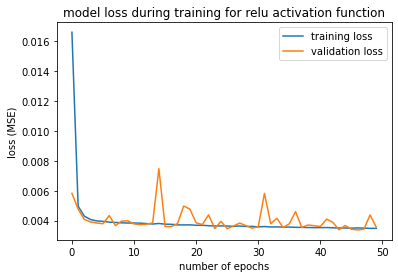


Training model with sigmoid activation function:
Epoch 1/50
704/704 - 2s - loss: 0.0243 - val_loss: 0.0191 - 2s/epoch - 2ms/step
Epoch 2/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0203 - 1s/epoch - 2ms/step
Epoch 3/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0191 - 1s/epoch - 2ms/step
Epoch 4/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0245 - 1s/epoch - 2ms/step
Epoch 5/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0190 - 1s/epoch - 2ms/step
Epoch 6/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0194 - 1s/epoch - 2ms/step
Epoch 7/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0296 - 1s/epoch - 2ms/step
Epoch 8/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0191 - 1s/epoch - 2ms/step
Epoch 9/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0195 - 1s/epoch - 2ms/step
Epoch 10/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0206 - 1s/epoch - 2ms/step
Epoch 11/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0191 - 1s/epoch - 2ms/step
Epoch 12/50
704/704 - 1s - loss: 0.0192 - val_loss: 0.0268 - 1s/epoc

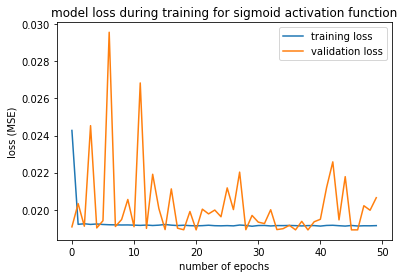

In [39]:
for a_fn in ["relu", "sigmoid"]:
    print("\nTraining model with {:s} activation function:".format(a_fn))
    model = create_model(lat_dim=100, a_fn=a_fn)
    history = run_model(model, n_epochs=50, lr=0.01)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss during training for {:s} activation function'.format(a_fn))
    plt.ylabel('loss (MSE)')
    plt.xlabel('number of epochs')
    plt.legend(['training loss', 'validation loss'], loc='upper right')
    plt.show()

Here we have a test MSE of 0.0037 for the ReLu activation function model, and 0.0207 for the sigmoid activation function model. The ReLu test MSE is therefore 82% smaller than the sigmoid test MSE, indicating that ReLu is a much better choice.

Additionally, we can see from the graphs and training/validation loss data that the training is much more effective for the ReLu model, as both the training and validation loss tend downwards throughout the training, with some limited fluctuation in the validation loss. For the sigmoid model, however, the validation loss is far more chaotic during training, and the spikes in loss for certain epochs are far greater. This confirms our choice of ReLu over sigmoid.

The reason that the ReLu activation function results in a better fitting is because the sigmoid function has a very large input space (real numbers) and a very small output space (0 to 1), so for most possible inputs, apart from a small range around 0, the gradient of the sigmoid function is close to 0. This means the gradient can easily become too small during optimisation, resulting in what is known as the Vanishing Gradient Problem, which causes the optimisation to slow down too quickly.

The ReLu activation function, on the other hand, is very effective for neural networks like this one, since it is very efficient (easy to calculate the gradient since it is a piecewise linear function) and avoids gradient saturation.

# P1.5

We now compare 19 different possible values for the lateral dimension `lat_dim`.

We use a learning rate of `0.01` (the best performing rate from P1.3) and a ReLu activation function (as we found in P1.4 it is superior to sigmoid in this case):

lat_dim = 1:
Training run 1: best test MSE is 0.0188
Training run 2: best test MSE is 0.0040
Training run 3: best test MSE is 0.0191
Training run 4: best test MSE is 0.0051
Training run 5: best test MSE is 0.0039
Mean of test MSE values for lat_dim=1 is 0.010177

lat_dim = 2:
Training run 1: best test MSE is 0.0042
Training run 2: best test MSE is 0.0191
Training run 3: best test MSE is 0.0040
Training run 4: best test MSE is 0.0041
Training run 5: best test MSE is 0.0039
Mean of test MSE values for lat_dim=2 is 0.007080

lat_dim = 3:
Training run 1: best test MSE is 0.0043
Training run 2: best test MSE is 0.0040
Training run 3: best test MSE is 0.0191
Training run 4: best test MSE is 0.0042
Training run 5: best test MSE is 0.0040
Mean of test MSE values for lat_dim=3 is 0.007127

lat_dim = 4:
Training run 1: best test MSE is 0.0041
Training run 2: best test MSE is 0.0043
Training run 3: best test MSE is 0.0043
Training run 4: best test MSE is 0.0039
Training run 5: best test MSE is 0.

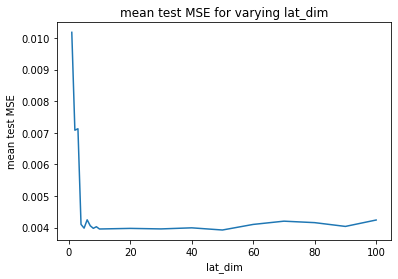

In [40]:
def run_model_with_checkpoints(model, lat_dim, n_epochs=10, lr=0.01, a_fn="relu", tr_num=0):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='mean_squared_error', metrics='mean_squared_error')

    best_model = ModelCheckpoint("/content/best_model_{:d}_{:d}.h5".format(lat_dim, tr_num+1), monitor='val_mean_squared_error', save_best_only=True, verbose=0, mode='min') # extract best model from training run
    model.fit(X_train, Y_train, epochs=n_epochs, batch_size=128, verbose=0, validation_split=0.1, callbacks = [best_model])
    #print('Test MSE: {:.4f}'.format(final_model.evaluate(X_test, Y_test, verbose=0)[1]))

def test_model_with_weights(model, weights, lat_dim, n_epochs=10, lr=0.01, a_fn="relu", tr_num=0):
    model.load_weights("/content/best_model_{:d}_{:d}.h5".format(lat_dim, tr_num+1))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr), loss='mean_squared_error')
    test_mse = model.evaluate(X_test, Y_test, verbose=0)
    # print('Test MSE for best model: {:.4f}'.format(test_mse))
    return test_mse

lat_dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lat_dims_mses = []
for lat_dim in lat_dims:
    test_mses = []
    print("lat_dim = {:d}:".format(lat_dim))
    for i in range(5):
        # print("Training run {:g} for latent dimension (lat_dim) of {:g}:".format(i+1, lat_dim))
        model = create_model(lat_dim=lat_dim)
        run_model_with_checkpoints(model, lat_dim, n_epochs=5, tr_num=i)
        trained_weights = h5py.File("/content/best_model_{:d}_{:d}.h5".format(lat_dim, i+1), 'r')
        test_mse = test_model_with_weights(model, trained_weights, lat_dim, n_epochs=5, tr_num=i)
        test_mses.append(test_mse)
        print('Training run {:g}: best test MSE is {:.4f}'.format(i+1, test_mse))
    mean_test_mses = sum(test_mses)/len(test_mses)
    print("Mean of test MSE values for lat_dim={:d} is {:f}\n".format(lat_dim, mean_test_mses))
    lat_dims_mses.append(mean_test_mses)
plt.plot(lat_dims,lat_dims_mses)
plt.title('mean test MSE for varying lat_dim'.format(a_fn))
plt.xlabel("lat_dim")
plt.ylabel("mean test MSE")
plt.show()

We can see from this graph that when `lat_dim` is too small (i.e. when it is less than about 4) the test MSE is much greater, so 4 seems to be about the minimum satisfactory value for `lat_dim`.

Increasing `lat_dim` further past 4 does not appear to significantly improve performance, as the mean test MSEs stay fairly stable as `lat_dim` increases further. If we continue to increase past around `60`, however, we start to see a drop in performance as the mean test MSEs creep up as `lat_dim` approaches `100`.

Since higher values of `lat_dim` introduce significantly more parameters (hence making the model more complex), our goal is to keep `lat_dim` as small as possible without degrading performance. To this end, these results suggest a `lat_dim` of around `4` to `5` would be the optimal choice.

Note there are some small spikes in mean test MSE for small values of `lat_dim` below `10`, and this suggests that we could benefit from increasing the number of independent training runs when `lat_dim` is small, to reduce the likelihood of getting a poorly trained model by chance.

Based on all the training we have done for P1, the optimal hyperparameter choices for this neural network are as follows:


*   `lat_dim = 4` (or `5`)
*   learning rate: `0.01`
*   activation function: ReLu



# P2.1

Below is the implementation of the permutation-equivariant neural network.

I created a custom layer using `keras` for the equivariant layers, based on the definition of a permutation-equivariant transformation:

$$f(\boldsymbol{X})=\boldsymbol{X}\boldsymbol{A}+\frac{1}{m}\boldsymbol{1}\boldsymbol{1}^\top\boldsymbol{X}\boldsymbol{B} + \boldsymbol{1}\boldsymbol{c}^\top$$

This layer is then combined with a ReLu activation function (for the `L-1` hidden layers).

The model is then created in `create_model` with the desired `L` number of layers, with each of the hidden layers having a width of `w`. `L` and `w` are both hyperparameters we can adjust later.

The model is trained with the Adam optimiser, which combines features of both AdaGrad and RMSProp. Adam therefore benefits from improved performance on problems with sparse gradients (like AdaGrad), as well as improved performance on problems with noisy data, since it updates the learning rate proportionally to the average of recent magnitudes of the gradients (specifically, proportional to $\frac{\text{average gradient}}{\sqrt{\text{average gradient norm}}}$, like RMSProp).

In [61]:
# load the datasets
X_train2 = np.reshape(read_csv('/content/xtrain-2.csv', index_col=0).to_numpy(), (200000, 5, 3))
Y_train2 = read_csv('/content/ytrain-2.csv', index_col=0)
X_test2 = np.reshape(read_csv('/content/xtest-2.csv', index_col=0).to_numpy(), (200000, 5, 3))
Y_test2 = read_csv('/content/ytest-2.csv', index_col=0)

# this class defines an equivariant layer, according to the definition given in the PDF
class EquivariantLayer(keras.layers.Layer):

    # initialise the layer
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(EquivariantLayer, self).__init__(**kwargs)

    # build the layer: create the two kernels and the bias vector
    def build(self, input_shape):
        self.layer_input_shape = input_shape
        self.kernel_1 = self.add_weight(name='kernel', shape=(input_shape[2], self.output_dim), trainable=True)
        self.kernel_2 = self.add_weight(name='kernel', shape=(input_shape[2], self.output_dim), trainable=True)
        self.bias_1 = self.add_weight(name='bias',shape=(self.output_dim,), trainable=True)
        super(EquivariantLayer, self).build(input_shape)

    # create the layer based on the definition of equivariant translations given in the PDF
    def call(self, x):
        # f(X) = XA + 1/m * XB + c
        output = tf.matmul(x, self.kernel_1) + tf.matmul(x, self.kernel_2)/self.layer_input_shape[1] + self.bias_1
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

def create_model(L=2, w=5):
    reset_backend()
    inputs = keras.Input(shape=(X_train2.shape[1],X_train2.shape[2]), name="inputs")
    x = inputs
    # add L-1 equivariant layers, each one followed by a ReLu activation function
    for i in range(L-1):
        x = EquivariantLayer(w)(x)
        x = keras.layers.Activation("relu")(x)
    # then add an equivariant output layer of dimension 1
    outputs = EquivariantLayer(1)(x)
    # outputs = keras.layers.Activation("softmax")(x) # softmax over sigmoid because choices are mutually exclusive
    return keras.Model(inputs=inputs, outputs=outputs, name="final_model")

def run_model(model, n_epochs=100, lr=1e-4):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-3), loss='mean_squared_error')
    history = model.fit(X_train2, Y_train2, epochs=n_epochs, batch_size=300, verbose=0, validation_split=0.1)
    return history

A summary of the neural network architecture (for `L=2`, `w=5`) is as follows:

In [62]:
create_model().summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 3)]            0         
                                                                 
 equivariant_layer (Equivari  (None, 5, 5)             35        
 antLayer)                                                       
                                                                 
 activation (Activation)     (None, 5, 5)              0         
                                                                 
 equivariant_layer_1 (Equiva  (None, 5, 1)             11        
 riantLayer)                                                     
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


And a visual representation of the network architecture:

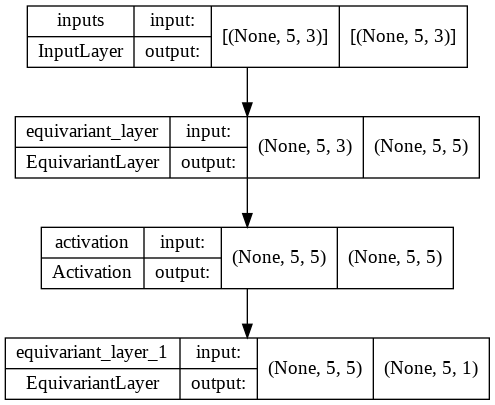

In [63]:
keras.utils.plot_model(create_model(), "model_with_shape_info.png", show_shapes=True)

# P2.2

We now train the neural network with various values of `L` and `w` for 100 epochs each, and plot the training and validation loss against the number of epochs. We also calculate the test MSE of each model in order to evaluate and compare their performance:


Test MSE for L = 2 and w = 5: 0.1600


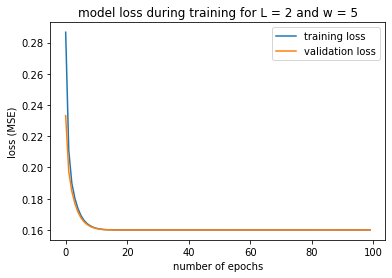


Test MSE for L = 2 and w = 10: 0.1600


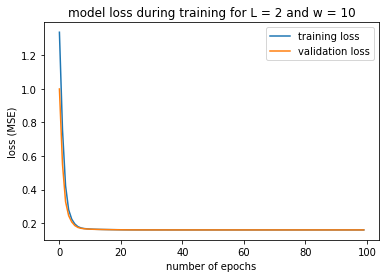


Test MSE for L = 2 and w = 100: 0.1490


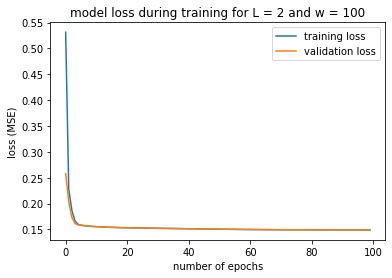


Test MSE for L = 2 and w = 200: 0.1491


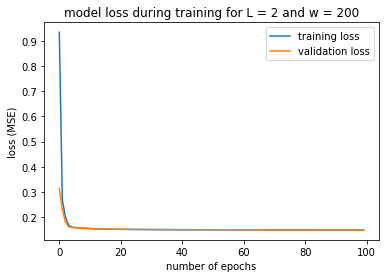


Test MSE for L = 3 and w = 5: 0.1600


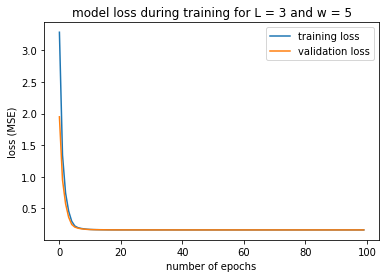


Test MSE for L = 3 and w = 10: 0.1488


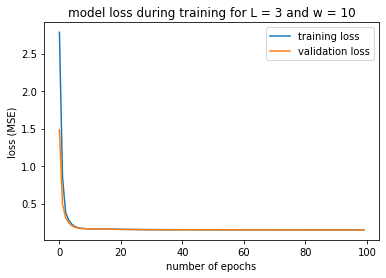


Test MSE for L = 3 and w = 100: 0.1488


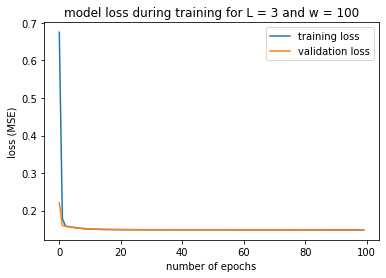


Test MSE for L = 3 and w = 200: 0.1488


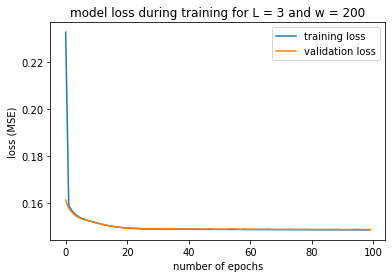

In [47]:
for L in [2, 3]:
    for w in [5, 10, 100, 200]:
        model = create_model(L=L, w=w)
        history = run_model(model)
        print('\nTest MSE for L = {:d} and w = {:d}: {:.4f}'.format(L, w, model.evaluate(X_test2, Y_test2, verbose=0)))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss during training for L = {:d} and w = {:d}'.format(L, w))
        plt.ylabel('loss (MSE)')
        plt.xlabel('number of epochs')
        plt.legend(['training loss', 'validation loss'], loc='upper right')
        plt.show()

These results show that the difference in test MSE for these different values of `L` and `w` is actually fairly minimal.

The worst performing models were when $(L,w)=(2,5)$, $(2,10)$, and $(3,5)$, each of which had a test MSE of `0.1600`. Meanwhile, the best performing models were when $(L,w)=(3,10)$, $(3,100)$ and $(3,200)$, each of which had a test MSE of `0.1488` (a 7% reduction).

However, it is worth noting that the number of parameters varies wildly between these models. For example, the $(L,w)=(2,5)$ model has just 46 parameters, while the $(L,w)=(3,200)$ model has 82,001 parameters. This results in a far longer training time, whilst also significantly increasing the model complexity.

Therefore, the optimal choice of `L` and `w` would be that which minimises loss while also not increasing the number of parameters by several orders of magnitude (as is the case for $(3,100)$ and $(3,200)$). $(L,w)=(3,10)$ would therefore be the optimal choice, since it achieves the best test MSE, whilst also only requiring 301 parameters.

All the graphs for these different options look fairly similar, with the only noticeable difference being the large variation in training MSE for the first epoch, after which all the graphs follow the same trend (although this 1st epoch loss variation is due to chance, not anything intrinsic in the models), with very quick training for the first few epochs, and improvement gradually slowing down to essentially flat by epoch 100.